In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import joblib
import re
import nltk
import seaborn as sns
from sklearn.decomposition import IncrementalPCA
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
nltk.download('wordnet')
nltk.download('punkt')
%matplotlib inline

#### reading emails from files

In [ ]:
import glob

def load_dataset(dirpath):
    """load emails from the specified directory"""

    files = []
    filepaths = glob.glob(dirpath + '/*')
    for path in filepaths:
        with open(path, 'rb') as f:
            byte_content = f.read()
            str_content = byte_content.decode('utf-8', errors='ignore')
            files.append(str_content)
    return files

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/MLProjects/datasets/spam/easy_ham.zip" -d "/content/"

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/MLProjects/datasets/spam/spam.zip" -d "/content/"

In [ ]:
easyHam = load_dataset("/content/easy_ham")
spam = load_dataset("/content/spam")

In [ ]:
content = easyHam + spam
label = np.concatenate((np.zeros((len(easyHam), 1)),  np.ones((len(spam), 1))), axis = 0).reshape(4402)
label.shape

(4402,)

In [47]:
#@markdown text Cleaning


In [ ]:
urlRegex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"

In [ ]:
for i in range(len(content)):
  #Convert hh:mm:ss to time
    content[i] = re.sub('\s\d{2}\:\d{2}\:\d{2}\s?', " time ", content[i])
      #Convert mail addresses to email
    content[i] = re.sub('(\w+-)?\w+@\w+(.\w+)?.\w{3}', " email ", content[i])
      #Convert URL addresses to url
    content[i] = re.sub(urlRegex, " url ", content[i])
      #Convert digits addresses to number
    content[i] = re.sub('[0-9]+', "number", content[i])
      # Remove extra white space from text
    content[i] = re.sub(r'\s+', ' ', content[i], flags=re.I)    
      # Remove all the special characters from textnge(len(content)):
    content[i] = re.sub(r'\W', ' ', str(content[i]))
      # Remove all single characters from text
    content[i] = re.sub(r'\s+[a-zA-Z]\s+', ' ', content[i])
      # Remove all <head> tags
    content[i]  = re.sub('<head.*?>.*?</head>', '', content[i] , flags=re.M | re.S | re.I)
      # Convert all <a> tags to hyperlink
    content[i]  = re.sub('<a\s.*?>', ' hyperlink ', content[i] , flags=re.M | re.S | re.I)
    # remove all html tags tags to hyperlink
    content[i]  = re.sub('<.*?>', '', content[i] , flags=re.M | re.S)
    # remove additional whitespaces
    content[i]  = re.sub(r'(\s*\n)+', '\n', content[i] , flags=re.M | re.S) 
    # conver to lowercase
    content[i] = content[i].lower()


In [ ]:
content[1].split("\n")

['from email wed jul number time number return path    email   delivered to  email received  from localhost  localhost  number number number number   by phobos labs netnoteinc com  postfix  with esmtp id fnumbercc for   email    wed  number jul number time  number  edt  received  from dogma slashnull org  number number number number  by localhost with imap  fetchmail number number number  for email  single drop   wed  number jul number time  number  ist  received  from xent com   number number number number   by dogma slashnull org  number number number number number number  with esmtp id gnumberobjmnumber for   email    wed  number jul number time  number received  from lair xent com  localhost  number number number number   by xent com  postfix  with esmtp id dnumberfanumber  wed  number jul number time  number  pdt  delivered to  email received  from hotmail com  oenumber lawnumber hotmail com  number number number number   by xent com  postfix  with esmtp id numberdnumber for   ema

In [48]:
#@markdown Creating dataset, and take a peek


In [ ]:
dataset = pd.DataFrame({'email' : content, 
                       'label'  : label})

In [ ]:
label = label.astype(int)

In [ ]:
joblib.dump(dataset, "/content/drive/MyDrive/Colab Notebooks/MLProjects/Spam/dataset")
joblib.dump(content, "/content/drive/MyDrive/Colab Notebooks/MLProjects/Spam/content")
joblib.dump(label, "/content/drive/MyDrive/Colab Notebooks/MLProjects/Spam/label")

In [ ]:
dataset = joblib.load("/content/drive/MyDrive/Colab Notebooks/MLProjects/Spam/dataset")
content = joblib.load("/content/drive/MyDrive/Colab Notebooks/MLProjects/Spam/content")
label = joblib.load("/content/drive/MyDrive/Colab Notebooks/MLProjects/Spam/label")

In [ ]:
dataset

,email,label
0,from email ie tue aug number time number retu...,0
1,from email wed jul number time number return p...,0
2,from email ie tue aug number time number retu...,0
3,from email thu sep number time number return p...,0
4,from email ie mon aug number time number retu...,0
...,...,...
4397,from email wed aug number time number return p...,1
4398,from email ie thu aug number time number retu...,1
4399,from email wed aug number time number return p...,1
4400,from email mon sep number time number return p...,1


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4402 entries, 0 to 4401
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   4402 non-null   object
 1   label   4402 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 68.9+ KB


0    3901
1     501
Name: label, dtype: int64


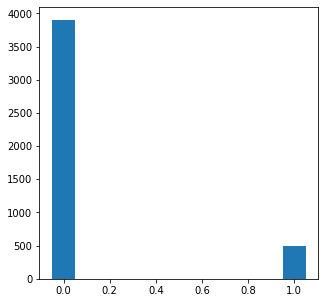

In [ ]:
value_counts = dataset.label.value_counts()
print(value_counts)
plt.figure(figsize=(5,5))
plt.bar(range(len(value_counts)),value_counts.values, width=.1)
plt.show()

max lenght: 18609, min length: 75, average length: 813
25th percentile: 524.0, 75th percentile: 891.0


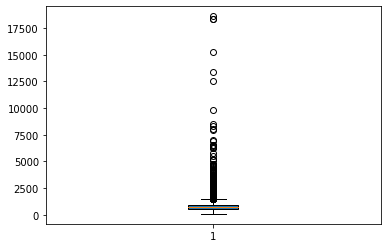

<Figure size 1440x720 with 0 Axes>

In [ ]:
mails_length = np.array([len(x.split(" ")) for x in dataset["email"]])
print(f"max lenght: {mails_length.max()}, min length: {mails_length.min()}, average length: {int(mails_length.mean())}")
print(f"25th percentile: {np.percentile(mails_length,25)}, 75th percentile: {np.percentile(mails_length,75)}")
plt.boxplot(mails_length,patch_artist=True)
plt.figure(figsize=(20,10))
plt.show()

In [ ]:
#@title Train, test split


In [49]:
xtrain, Xtest, ytrain, Ytest = train_test_split(content, label, test_size = .2, random_state=42)

In [ ]:
#@markdown using nltk  for tokenizing, stemming and lematizing, and ceating vocabulary


In [ ]:

stm = nltk.stem.PorterStemmer()
lem = WordNetLemmatizer()

vocab = []
def tokenizer(mail):
    for token in nltk.word_tokenize(mail):
          if token in string.punctuation : continue
          vocab.append(lem.lemmatize(stm.stem(token)))  

In [ ]:
for x in content:
    tokenizer(x)
vocab_set = set(vocab)

In [ ]:
len(vocab_set)

75435

In [ ]:
joblib.dump(vocab_set, "/content/drive/MyDrive/Colab Notebooks/MLProjects/Spam/vocabs")
len(vocab_set)

75435

In [ ]:
vocab = joblib.load( "/content/drive/MyDrive/Colab Notebooks/MLProjects/Spam/vocabs")
len(vocab)

75435

In [ ]:
#@markdown Vectorizing our emails


In [ ]:
tf_idf = TfidfVectorizer(vocabulary=vocab, lowercase=False, stop_words = 'english', ) 
tf_idf.fit(content)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=No...
                            '______________________________________________',
                            '_______________________________________________',
                            '________________________________________________',
                            '_________________________________________________',
                            '__________________________________________________',
                            '___________________________________________________',
                            '__________________

In [ ]:
X_train_idf = pd.DataFrame(tf_idf.transform(xtrain).toarray())
X_test_idf = pd.DataFrame(tf_idf.transform(Xtest).toarray())

In [ ]:
X_train_idf.shape

(3521, 75435)

In [ ]:
X_train_idf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3521 entries, 0 to 3520
Columns: 75435 entries, 0 to 75434
dtypes: float64(75435)
memory usage: 2.0 GB


In [ ]:
#@title our date is very big, so we have to reduce it's dim


In [ ]:
n_batches = 10
inc_pca = IncrementalPCA(n_components=350)
for X_batch in np.array_split(X_train_idf, n_batches):
      inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train_idf)
X_test_reduced = inc_pca.transform(X_test_idf)


In [ ]:
X_reduced.shape

(3521, 350)

In [ ]:
#@title Model Selection


In [ ]:
models = [
    LogisticRegression(), SGDClassifier(), KNeighborsClassifier(),
    GaussianNB(), RandomForestClassifier()
]
scoring = {'acc': 'accuracy',
           'f1': 'f1'
          }
for model in models:
    model_name = type(model).__name__
    cross_score = cross_validate(estimator=model, X=X_reduced, y=ytrain, cv=3, scoring=scoring,
                                    return_train_score=True)
    print(f"Model : {model_name}")
    for key in cross_score.keys():
            print(f"{key} : {cross_score[key]}")
    print("######################################")

Model : LogisticRegression
fit_time : [0.0656991  0.06106663 0.04566526]
score_time : [0.00320816 0.00305247 0.00303531]
test_acc : [0.94207836 0.93611584 0.93265132]
train_acc : [0.94162761 0.94077546 0.94250426]
test_f1 : [0.67619048 0.62311558 0.59487179]
train_f1 : [0.66666667 0.6601467  0.6746988 ]
######################################
Model : SGDClassifier
fit_time : [0.04109693 0.03062892 0.0393765 ]
score_time : [0.00323462 0.00335145 0.00329471]
test_acc : [0.99488927 0.98977853 0.99147485]
train_acc : [0.99488709 0.99616532 0.99574106]
test_f1 : [0.97777778 0.95522388 0.96212121]
train_f1 : [0.97769517 0.98330241 0.98141264]
######################################
Model : KNeighborsClassifier
fit_time : [0.1097784  0.08364081 0.08317423]
score_time : [1.76857185 1.7883637  1.81453276]
test_acc : [0.97870528 0.9770017  0.97357204]
train_acc : [0.98508735 0.98849595 0.9850937 ]
test_f1 : [0.90118577 0.89411765 0.88030888]
train_f1 : [0.93358634 0.94915254 0.93333333]
##########

In [ ]:
#@markdown predict values for test set


In [ ]:
final_model = SGDClassifier()
final_model.fit(X_reduced, ytrain)
y_pred = final_model.predict(X_test_reduced)

In [ ]:

f1 = f1_score(Ytest, y_pred)
acc = accuracy_score(Ytest, y_pred)
print(f"SGD : f1_score : {f1}, accuracy_score = {acc} ")

SGD : f1_score : 0.967032967032967, accuracy_score = 0.9931895573212258 


In [ ]:

conf_matrix = confusion_matrix(Ytest, y_pred)
conf_matrix

array([[787,   1],
       [  5,  88]])

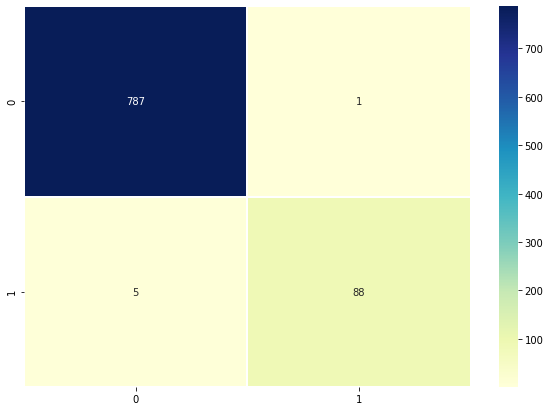

In [ ]:
plt.figure(figsize = (10,7))
labeld
sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True ,linewidths=1, fmt="d", )